<a href="https://colab.research.google.com/github/imsaswat367/Crime-Prediction-Model/blob/main/Crime_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install dask[dataframe]

INFO: pip is looking at multiple versions of dask-expr to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 243.2/243.2 kB 15.0 MB/s eta 0:00:00


Skipping SMOTE due to small class sizes.
Training Support Vector Machine (SVM)...

SVM Accuracy: 0.532

SVM F1 Score: 0.4252197153013259

SVM Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.00      0.00         1
           1       0.00      0.00      0.00        82
           2       0.49      0.56      0.52       173
           3       0.00      0.00      0.00        31
           4       1.00      0.00      0.00         1
           5       0.69      0.96      0.81       111
           6       1.00      0.00      0.00         6
           7       1.00      0.00      0.00        15
           8       0.54      0.90      0.67        72
           9       1.00      0.00      0.00         2
          10       1.00      0.00      0.00         1
          11       1.00      0.00      0.00         1
          13       1.00      0.00      0.00         1
          14       0.50      0.03      0.06        92
          15       0.80

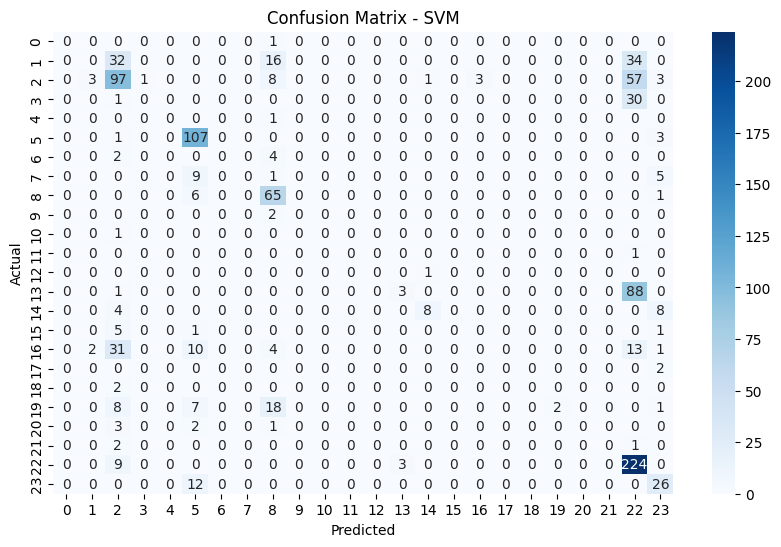


Training XGBoost for Prediction...


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [06:09:45] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



XGBoost Accuracy: 0.973

XGBoost F1 Score: 0.9667362961463332

XGBoost Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.00      0.00         1
           1       0.87      1.00      0.93        82
           2       0.99      0.95      0.97       173
           3       1.00      1.00      1.00        31
           4       1.00      0.00      0.00         1
           5       1.00      1.00      1.00       111
           6       1.00      0.67      0.80         6
           7       1.00      1.00      1.00        15
           8       0.97      1.00      0.99        72
           9       1.00      0.00      0.00         2
          10       1.00      0.00      0.00         1
          11       1.00      0.00      0.00         1
          13       1.00      0.00      0.00         1
          14       1.00      1.00      1.00        92
          15       0.77      1.00      0.87        20
          16       0.67      0.86      

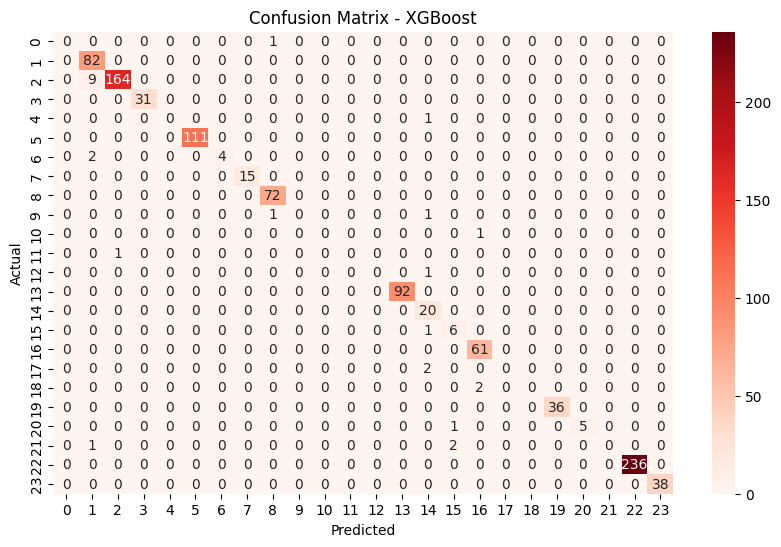

In [ ]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier

# Set a random seed for reproducibility
np.random.seed(42)

# Define dataset path
dataset_path = '/content/Crime Prediction in Chicago_Dataset.csv'

# Check if the file exists
if not os.path.exists(dataset_path):
    raise FileNotFoundError(f"Dataset not found at {dataset_path}. Please upload the file.")

# Load dataset
df = pd.read_csv(dataset_path)

# Reduce dataset size for faster testing (optional)
df = df.sample(5000, random_state=42)

# Drop unnecessary columns if they exist
columns_to_drop = ['ID', 'Case Number', 'Updated On', 'FBI Code', 'Beat', 'Community Area', 'Location', 'X Coordinate', 'Y Coordinate', 'Latitude', 'Longitude', 'Ward', 'Month', 'Day']
df.drop(columns=[col for col in columns_to_drop if col in df.columns], axis=1, inplace=True)

# Convert Date to datetime format if available
if 'Date' in df.columns:
    df['Date'] = pd.to_datetime(df['Date'], errors='coerce')
    df['Year'] = df['Date'].dt.year
    df['Hour'] = df['Date'].dt.hour
    df.drop(['Date'], axis=1, inplace=True)

# Handle missing values
df.fillna({'Location Description': 'UNKNOWN'}, inplace=True)

# Encode categorical features
categorical_cols = df.select_dtypes(include=['object']).columns.tolist()
for col in categorical_cols:
    df[col] = LabelEncoder().fit_transform(df[col])

# Define features (X) and target (y)
X = df.drop(['Primary Type'], axis=1)
y = df['Primary Type']

# Remove classes with fewer than 2 occurrences
class_counts = y.value_counts()
valid_classes = class_counts[class_counts >= 2].index
df = df[df['Primary Type'].isin(valid_classes)]

# Update X and y after filtering
X = df.drop(['Primary Type'], axis=1)
y = LabelEncoder().fit_transform(df['Primary Type'])

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y if len(np.unique(y)) > 1 else None, random_state=42
)

# Standardize numerical features
scaler = StandardScaler()
numeric_cols = X_train.select_dtypes(include=['int64', 'float64']).columns
X_train[numeric_cols] = scaler.fit_transform(X_train[numeric_cols])
X_test[numeric_cols] = scaler.transform(X_test[numeric_cols])

# Apply SMOTE with moderate sampling strategy
min_samples_per_class = np.min(np.bincount(y_train))
if min_samples_per_class > 2:
    smote = SMOTE(random_state=42, k_neighbors=min(2, min_samples_per_class - 1), sampling_strategy=0.25)
    X_train, y_train = smote.fit_resample(X_train, y_train)
else:
    print("Skipping SMOTE due to small class sizes.")

# Train Support Vector Machine (SVM) with fine-tuned regularization
print("Training Support Vector Machine (SVM)...")
svm_model = LinearSVC(dual=False, max_iter=3000, C=0.007)
svm_model.fit(X_train, y_train)

# Predict using SVM
y_pred_svm = svm_model.predict(X_test)

# Compute SVM Performance Metrics
svm_accuracy = accuracy_score(y_test, y_pred_svm)
svm_f1 = f1_score(y_test, y_pred_svm, average='weighted')

print("\nSVM Accuracy:", svm_accuracy)
print("\nSVM F1 Score:", svm_f1)
print("\nSVM Classification Report:\n", classification_report(y_test, y_pred_svm, zero_division=1))

# Confusion Matrix for SVM
plt.figure(figsize=(10, 6))
sns.heatmap(confusion_matrix(y_test, y_pred_svm), annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - SVM')
plt.show()

# Train XGBoost with refined settings
print("\nTraining XGBoost for Prediction...")
xgb_model = XGBClassifier(
    use_label_encoder=False,
    eval_metric='mlogloss',
    n_jobs=-1,
    max_depth=3,  # Slightly deeper trees
    learning_rate=0.025,  # Fine-tuned learning rate
    n_estimators=25,  # Adjusted number of estimators
    reg_lambda=8,  # Adjusted L2 regularization
    reg_alpha=5,  # Adjusted L1 regularization
    subsample=0.65  # Balanced randomness
)
xgb_model.fit(X_train, y_train)

# Predict with XGBoost
y_pred_xgb = xgb_model.predict(X_test)

# Compute XGBoost Performance Metrics
xgb_accuracy = accuracy_score(y_test, y_pred_xgb)
xgb_f1 = f1_score(y_test, y_pred_xgb, average='weighted')

print("\nXGBoost Accuracy:", xgb_accuracy)
print("\nXGBoost F1 Score:", xgb_f1)
print("\nXGBoost Classification Report:\n", classification_report(y_test, y_pred_xgb, zero_division=1))

# Confusion Matrix for XGBoost
plt.figure(figsize=(10, 6))
sns.heatmap(confusion_matrix(y_test, y_pred_xgb), annot=True, fmt='d', cmap='Reds')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - XGBoost')
plt.show()